## FX Market Making - Partial VS Zero Hedging
I model FX as a GBM
Spot FX starts at 1  
Volatility is 10%/year   
Poisson frequency $\lambda$ for client trade arrival is 1 trade/second  
even odds For A Sell or Buy Order from Clients  
Bid/ask spread for client trades is 1bp   
Bid/ask spread for inter-dealer hedge trades is 2bp  
A delta limit of 3 units before the algorithm executes a hedge in the inter-dealer market.   


In [1]:
import random as rd
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
class MarketMaker():
        
    def __init__(self, annualized_vola,  numtimesteps, tradingIntensity, rng):
        lambd = tradingIntensity
        timestepspersecond = lambd / 0.1
        sigma  = annualized_vola/ np.sqrt(250*24*3600*timestepspersecond) 
        T = numtimesteps
        lambd = tradingIntensity
        brownian_steps = rng.normal(0,sigma,T) # an array of sigma*(W_t - W_t-1)
        self.FX = np.empty(len(brownian_steps) +1)
        self.FX[0] = 1.0
        for i in range(1,len(brownian_steps) + 1):
            self.FX[i] = self.FX[i-1]*(1 + brownian_steps[i-1])
        self.PartialHedge_pos = 0
        self.PartialHedge_PNL = 0
        self.FullHedge_pos = 0
        self.FullHedge_PNL = 0
        self.delta = 3 #we can change this eventually
        self.client_spead = 0.0001 #1bps
        self.hedge_spread = 0.0002 #2bps
        self.PNLS = [[], []]
        
    def client_order(self, timestep, ordertype): #clients only buy/sells one unit P(Buy|Trade) = 0.5
        if ordertype == 1: #buy order
            self.PartialHedge_pos -= 1
            self.FullHedge_pos -= 1
        else:
            self.PartialHedge_pos += 1
            self.FullHedge_pos += 1
        self.PartialHedge_PNL += self.client_spead*self.FX[timestep]/2.0
        self.FullHedge_PNL += self.client_spead*self.FX[timestep]/2.0
         
        
    def hedge(self, timestep): 
        if abs(self.PartialHedge_pos) > self.delta :
            self.PartialHedge_PNL -=  self.hedge_spread * self.FX[timestep] * (abs(self.PartialHedge_pos) - 3) / 2.0
            self.PartialHedge_pos = self.delta if self.PartialHedge_pos > 0 else -self.delta
            
        if abs(self.FullHedge_pos) > self.delta :
            self.FullHedge_PNL -=  self.hedge_spread * self.FX[timestep] * (abs(self.FullHedge_pos)) / 2.0
            self.FullHedge_pos = 0.0
          
            
    def updatepnl(self, timestep):
        self.PartialHedge_PNL+= self.PartialHedge_pos *(self.FX[timestep+1] - self.FX[timestep ] )
        self.FullHedge_PNL += self.FullHedge_pos* (self.FX[timestep+1] -  self.FX[timestep])
        self.PNLS[0].append(self.PartialHedge_PNL) 
        self.PNLS[1].append(self.FullHedge_PNL) 
        

In [9]:
PNLS = [[], []]
nbtrades = []
N = 50000
T = 500    
intensity = 1.0
for X in range(N):
    rng = np.random.default_rng(X)
    MM = MarketMaker(0.1, T, intensity, rng)
    nbtrade = 0
    for i in range(T):
        if rng.poisson(lam=intensity*0.1, size=1) >= 1:
            nbtrade+=1
            MM.client_order(i,rng.integers(low = 0, high=2, size=1, dtype=np.int64, endpoint=False))
            MM.hedge(i)
        MM.updatepnl(i)
    PNLS[0].append(MM.PNLS[0])
    PNLS[1].append(MM.PNLS[1])
    nbtrades.append(nbtrade)
    
nbtrades = np.array(nbtrades)
df1 = pd.DataFrame(PNLS[0])
df2 = pd.DataFrame(PNLS[1])
partial_mean =  df1.mean(axis=0)
partial_std =  df1.std(axis=0)
full_mean =  df2.mean(axis=0)
full_std =  df2.std(axis=0)

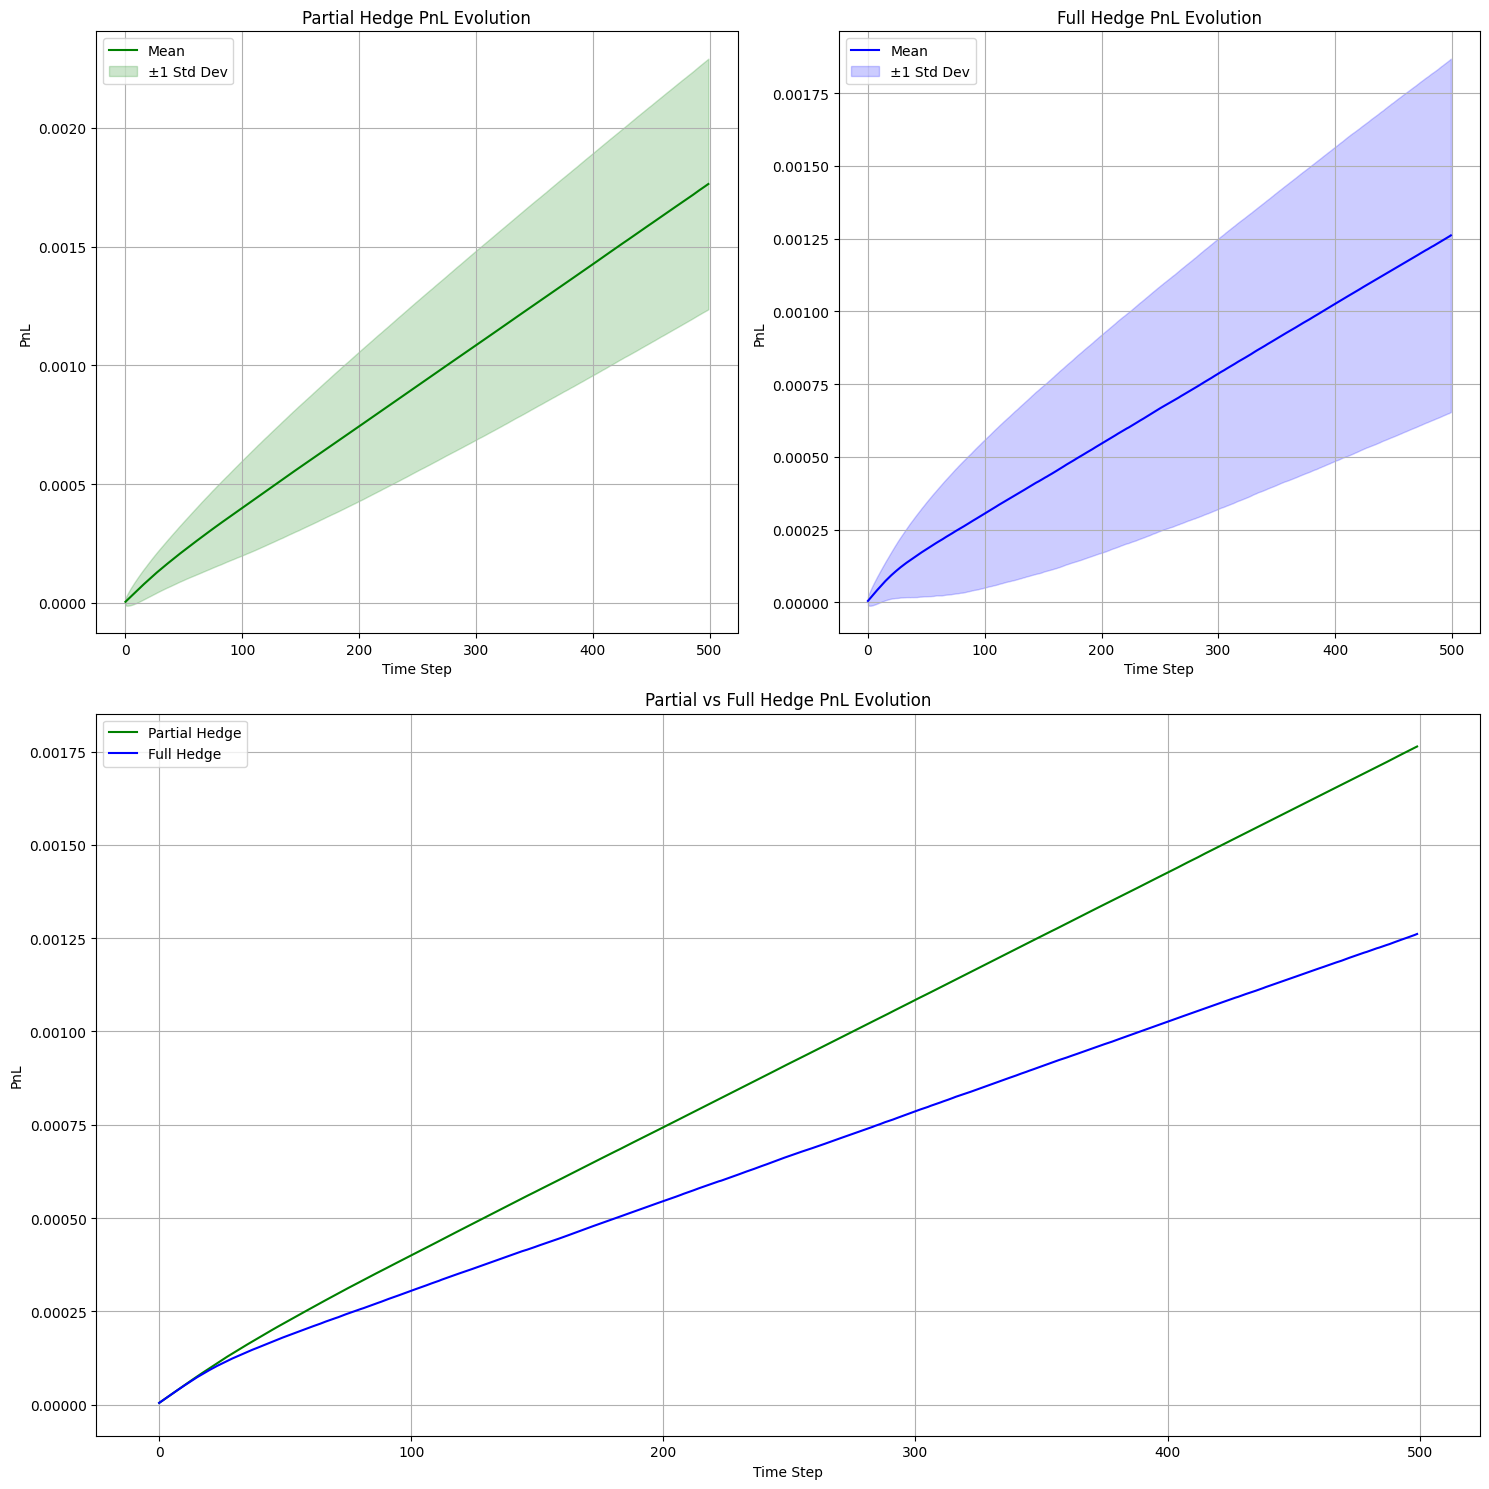

In [36]:

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.2])  


ax1 = fig.add_subplot(gs[0, 0])      
ax2 = fig.add_subplot(gs[0, 1])      
ax3 = fig.add_subplot(gs[1, :])      

x_axis = np.arange(0, T)
ax1.plot(x_axis, partial_mean, label='Mean', color='green')
ax1.fill_between(x_axis, partial_mean - partial_std, partial_mean + partial_std,
                 color='green', alpha=0.2, label='±1 Std Dev')
ax1.set_title("Partial Hedge PnL Evolution")
ax1.set_xlabel('Time Step')
ax1.set_ylabel('PnL')
ax1.legend()
ax1.grid(True)


ax2.plot(x_axis, full_mean, label='Mean', color='blue')
ax2.fill_between(x_axis, full_mean - full_std, full_mean + full_std,
                 color='blue', alpha=0.2, label='±1 Std Dev')
ax2.set_title("Full Hedge PnL Evolution")
ax2.set_xlabel('Time Step')
ax2.set_ylabel('PnL')
ax2.legend()
ax2.grid(True)

ax3.plot(x_axis, partial_mean, label='Partial Hedge', color='green')
ax3.plot(x_axis, full_mean, label='Full Hedge', color='blue')
ax3.set_title("Partial vs Full Hedge PnL Evolution")
ax3.set_xlabel('Time Step')
ax3.set_ylabel('PnL')
ax3.legend()
ax3.grid(True)

fig.tight_layout()
plt.show()


In [38]:
print(f"The Sharp Ratio for the Partial Hedging MM Strat is {partial_mean.iloc[-1] / partial_std.iloc[-1] :.3f}")
print(f"The Sharp Ratio for the Full Hedging MM Strat is {full_mean.iloc[-1] / full_std.iloc[-1]:.3f}")
print(f"Mean number of trades {nbtrades.mean():.3f}")
print(f"Std number of trades {nbtrades.std():3f}")

The Sharp Ratio for the Partial Hedging MM Strat is 3.343
The Sharp Ratio for the Full Hedging MM Strat is 2.077
Mean number of trades 47.587
Std number of trades 6.556845


The results suggest that althought with partial hedging, we would rebalance more frenquently for the same number of trades, the  the number of trades which is quite small 43, made the cost incurred by large infrequent rebalancing be larger.